In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

In [3]:
train_dir = './datasets/10_food_classes_10_percent/train'
test_dir = './datasets/10_food_classes_10_percent/test'

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [5]:
train_data_10_precent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')


test_data_10_precent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [6]:
# setting callbacks

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    
    return tensorboard_callback

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# crate a keras sequential model from a tensorflow hub model

def create_model(model_url, num_classes):
    
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable = False,
                                             name = 'feature_extraction_layer',
                                             input_shape = IMAGE_SHAPE + (3,))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes,
                     activation = 'softmax',
                     name = 'output_layer')
    ])
    
    return model

In [11]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_precent.num_classes)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# the only trainable parameters are the output layer

In [14]:
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = 'Adam',
                     metrics = ['accuracy'])

In [15]:
resnet_history = resnet_model.fit(train_data_10_precent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_precent),
                                  validation_data = test_data_10_precent,
                                  validation_steps = len(test_data_10_precent),
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name='resnet50V2')])

Epoch 1/5
24/24 [==============================] - 122s 5s/step - loss: 1.9844 - accuracy: 0.3147 - val_loss: 1.1942 - val_accuracy: 0.6200
Epoch 2/5
24/24 [==============================] - 111s 5s/step - loss: 0.9353 - accuracy: 0.7000 - val_loss: 0.8353 - val_accuracy: 0.7404
Epoch 3/5
24/24 [==============================] - 107s 5s/step - loss: 0.6474 - accuracy: 0.7973 - val_loss: 0.7568 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 107s 5s/step - loss: 0.4986 - accuracy: 0.8653 - val_loss: 0.6971 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 106s 5s/step - loss: 0.4025 - accuracy: 0.8973 - val_loss: 0.6658 - val_accuracy: 0.7756


In [20]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend();
    
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

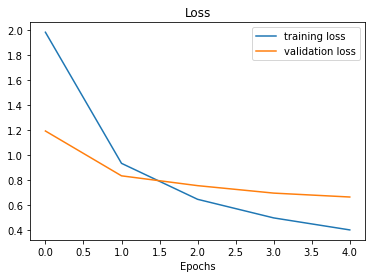

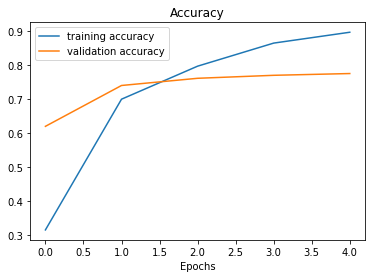

In [21]:
plot_loss_curves(resnet_history)